# Modular modeling framework example
This notebook shows how a fitting framework could be made,
    in the context of [issue #81](https://github.com/sunpy/sunkit-spex/issues/81) and [issue #126](https://github.com/sunpy/sunkit-spex/issues/126).

`sunkit-spex` has (or will have?) a modular interface.
First we define the data interface.
For now it is only X-ray data but we can add more data types.

Then we define the fitting interface.
A `PhotonModel` represents any kind of model which represents photons which get counted.
In the future we can add different models, like `IntegratedFluxModels` if the
    need arises; there is not a need to tie us to a base class right now.

The first example tackled here is fitting data to a line.
More complex models may be implemented however the user or developers see fit
    by modifying the `perform_fit` method in subsequent classes.
The first class implemented is a Monte Carlo $\chi^2$ fitter.

A lot of ideas here are similar to [pr #130](https://github.com/sunpy/sunkit-spex/pull/130).
I think we should pick and choose what we like from both and move from there.

In [1]:
from sunkit_spex.fitting import fit_models
from sunkit_spex.fitting import fake_models
from sunkit_spex.fitting import fitters

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Make and plot some fake data (just a linear process)

In [2]:
import importlib
importlib.reload(fake_models)
importlib.reload(fitters)
importlib.reload(fit_models)
spec = fake_models.linear(slope=100, intercept=2000)
print('attributes of', spec.__class__)
[attr for attr in dir(spec) if not attr.startswith('_')]

attributes of <class 'sunkit_spex.fitting.spectra.XraySpectrum'>


['count_energy_edges',
 'counts',
 'counts_de',
 'counts_error',
 'effective_exposure',
 'photon_energy_edges',
 'photons_de',
 'response_matrix']

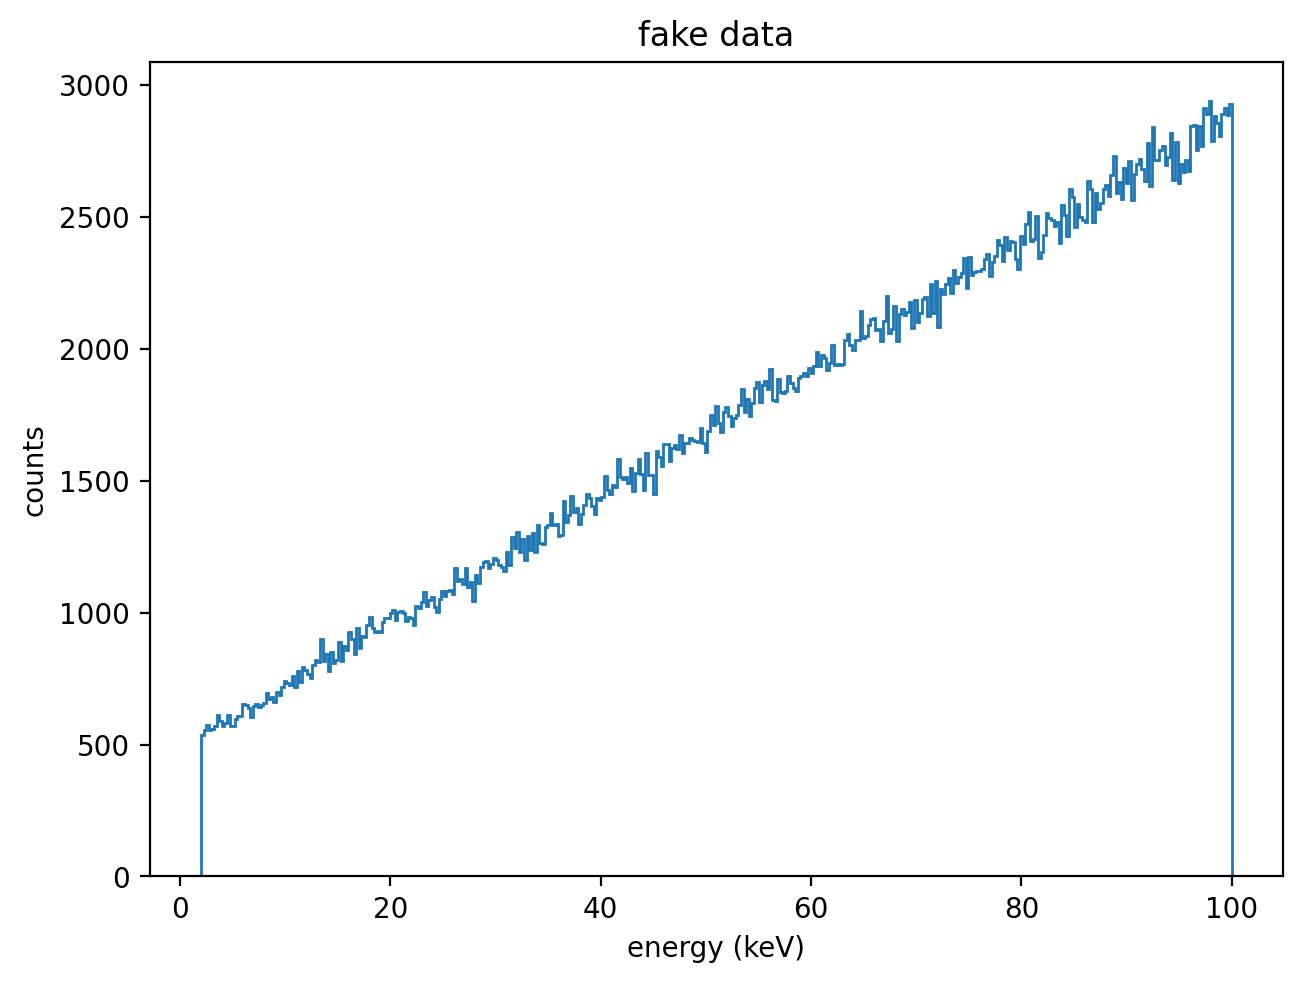

In [3]:
fig, ax = plt.subplots(layout='constrained')
ax.stairs(spec.counts.to_value(u.ct), spec.count_energy_edges.to_value(u.keV))
ax.set(xlabel='energy (keV)', ylabel='counts', title='fake data')
plt.show()

In [4]:
# Make a model to fit the fake data and make its parameters off by a bit
mod = fit_models.Line()
mod.slope.value = 80
mod.intercept.value = 1000

# Units are enforced seamlessly
print(mod.current_parameters())

# But they do cause errors if you try to apply the wrong unit.
try:
    mod.slope.value = 1 << u.newton
except u.UnitConversionError as e:
    print('caught the issue:', '; '.join(e.args))

OrderedDict({'slope': ModelParameter<80.0 ph / (s cm2 keV2) | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3b1ffe1940>>, 'intercept': ModelParameter<1000.0 ph / (keV s cm2) | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3b203924b0>>})
caught the issue: 'N' (force) and 'ph / (s cm2 keV2)' are not convertible


In [5]:
# Start the fitter & fit the data
fitter = fitters.MonteCarloChi2Fitter(spectral_data=spec, photon_model=mod)
fitter.perform_fit(num_steps=1000)

# We can save it for later if we want
# fitter.save(fn='babys-first-fit.dill')

/home/william/Desktop/sunkitspex-dev/skitspex-dev/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


## Fitting is done. Let's plot the results

### Plot the "posterior" parameter distributions

In [6]:
names = list(fitter.model_parameters().keys())
units = {k: v.value.unit for (k, v) in fitter.model_parameters().items()}
samp = fitter.emcee_sampler
chain = samp.get_chain(flat=True)

medians = {k: np.median(chain[:, i]) for (i, k) in enumerate(names)}
stdevs = {k: np.std(chain[:, i]) for (i, k) in enumerate(names)}

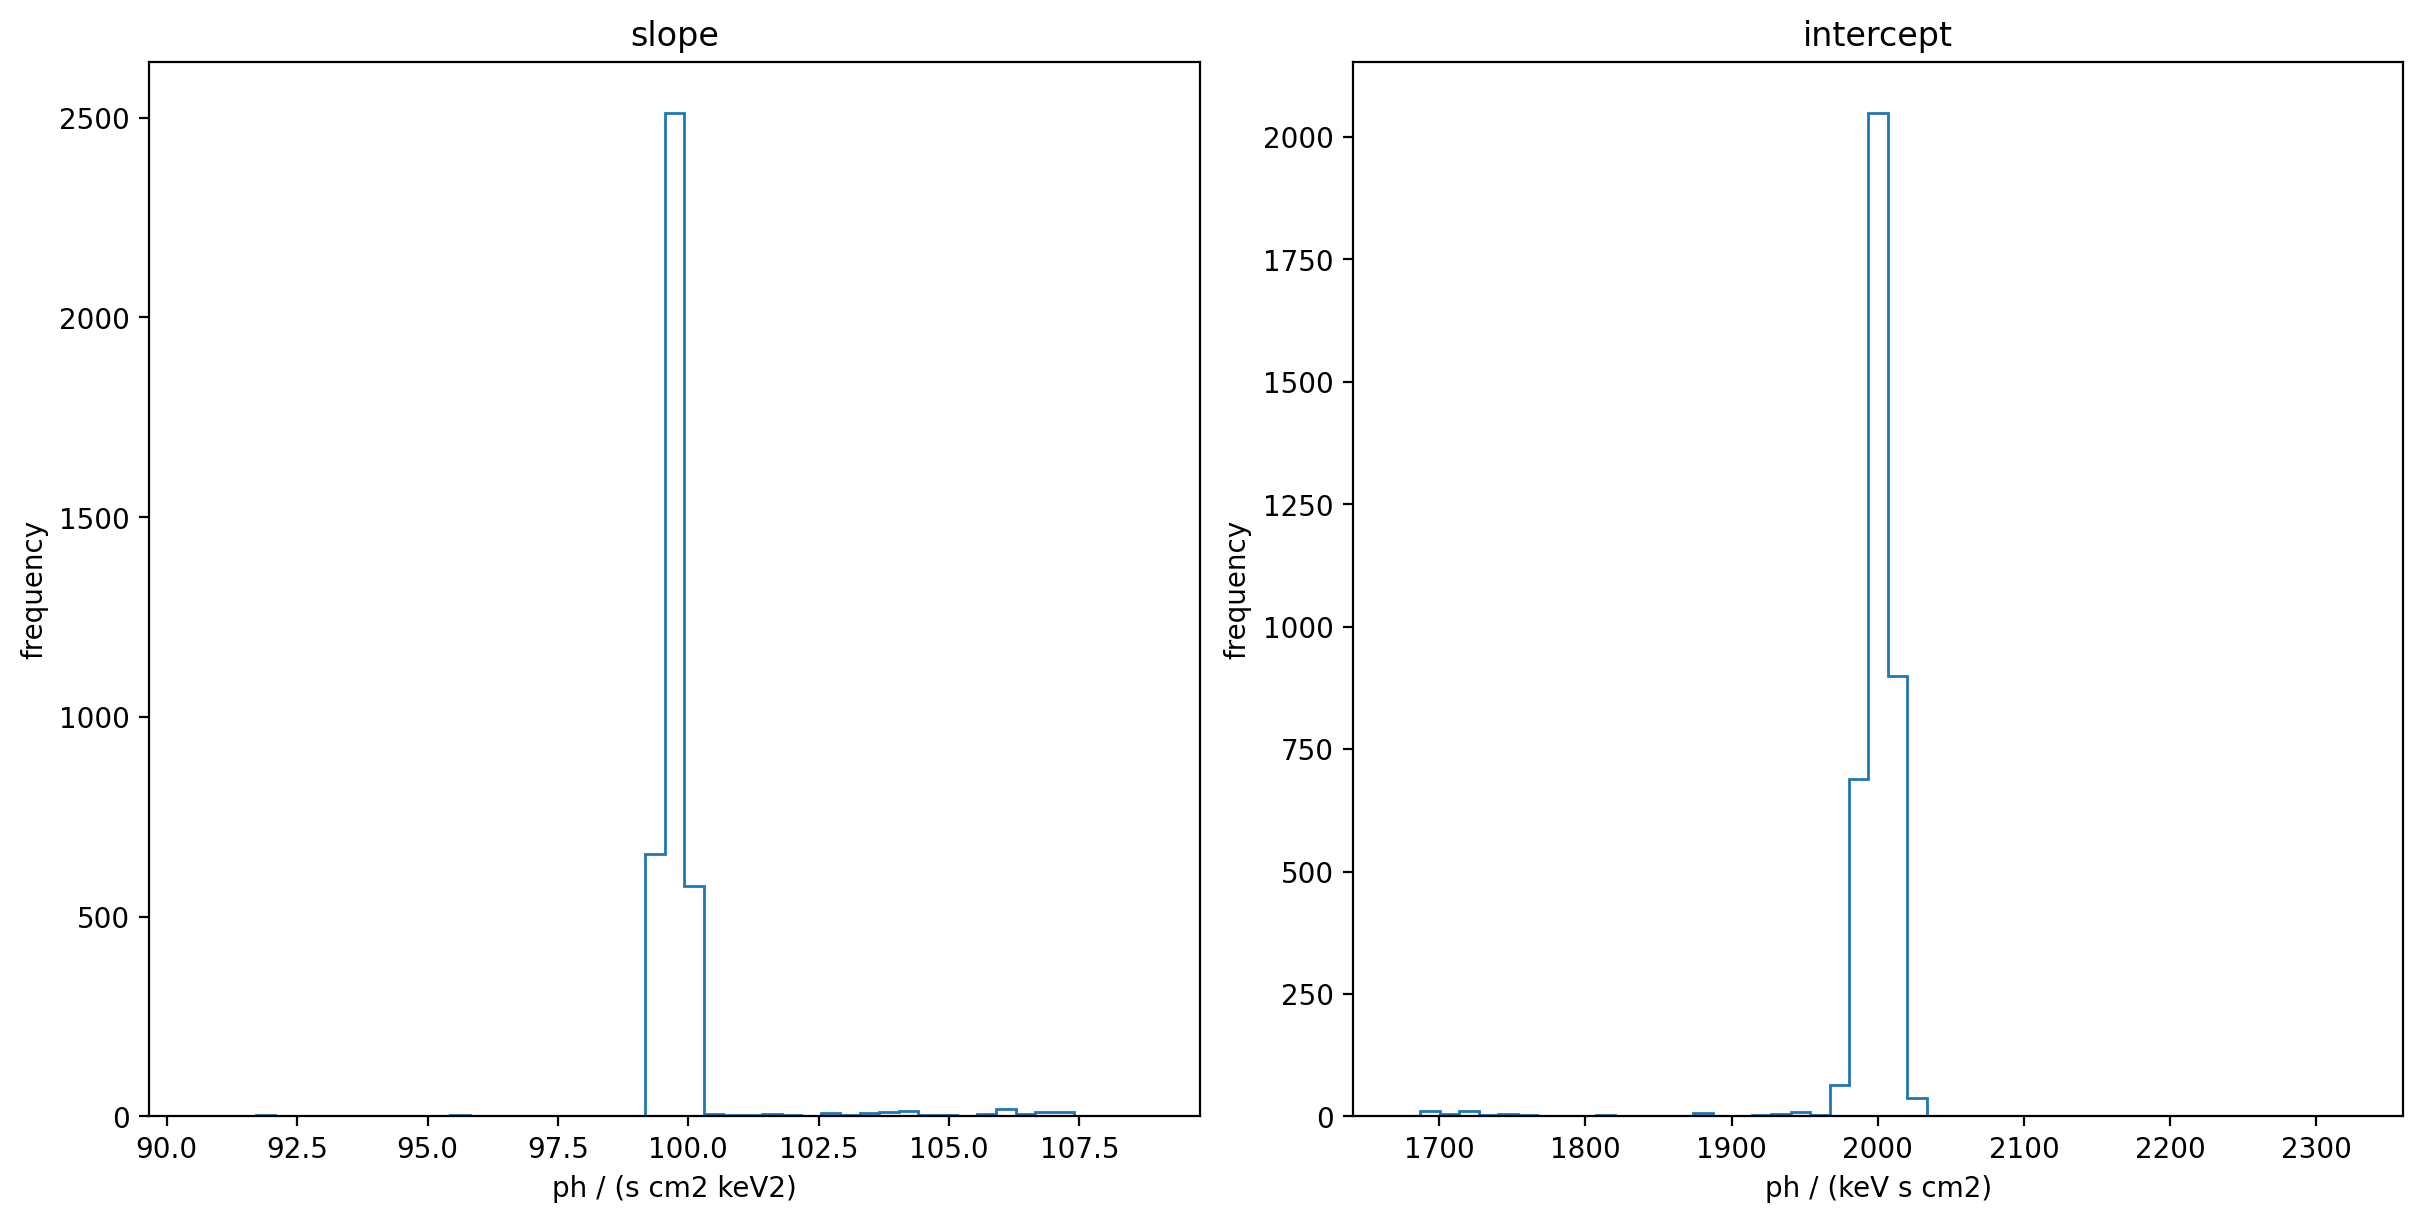

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=1, layout='constrained', figsize=(12, 6))
for i, (ax, k) in enumerate(zip(axs, medians.keys())):
    med, std = medians[k], stdevs[k]
    bins = np.linspace(med - 2*std, med + 2*std, num=50)
    hg, _ = np.histogram(chain[:, i], bins=bins)
    ax.stairs(hg, bins)
    ax.set(title=k, xlabel=units[k], ylabel='frequency')
plt.show()

### Let's plot some of the fits

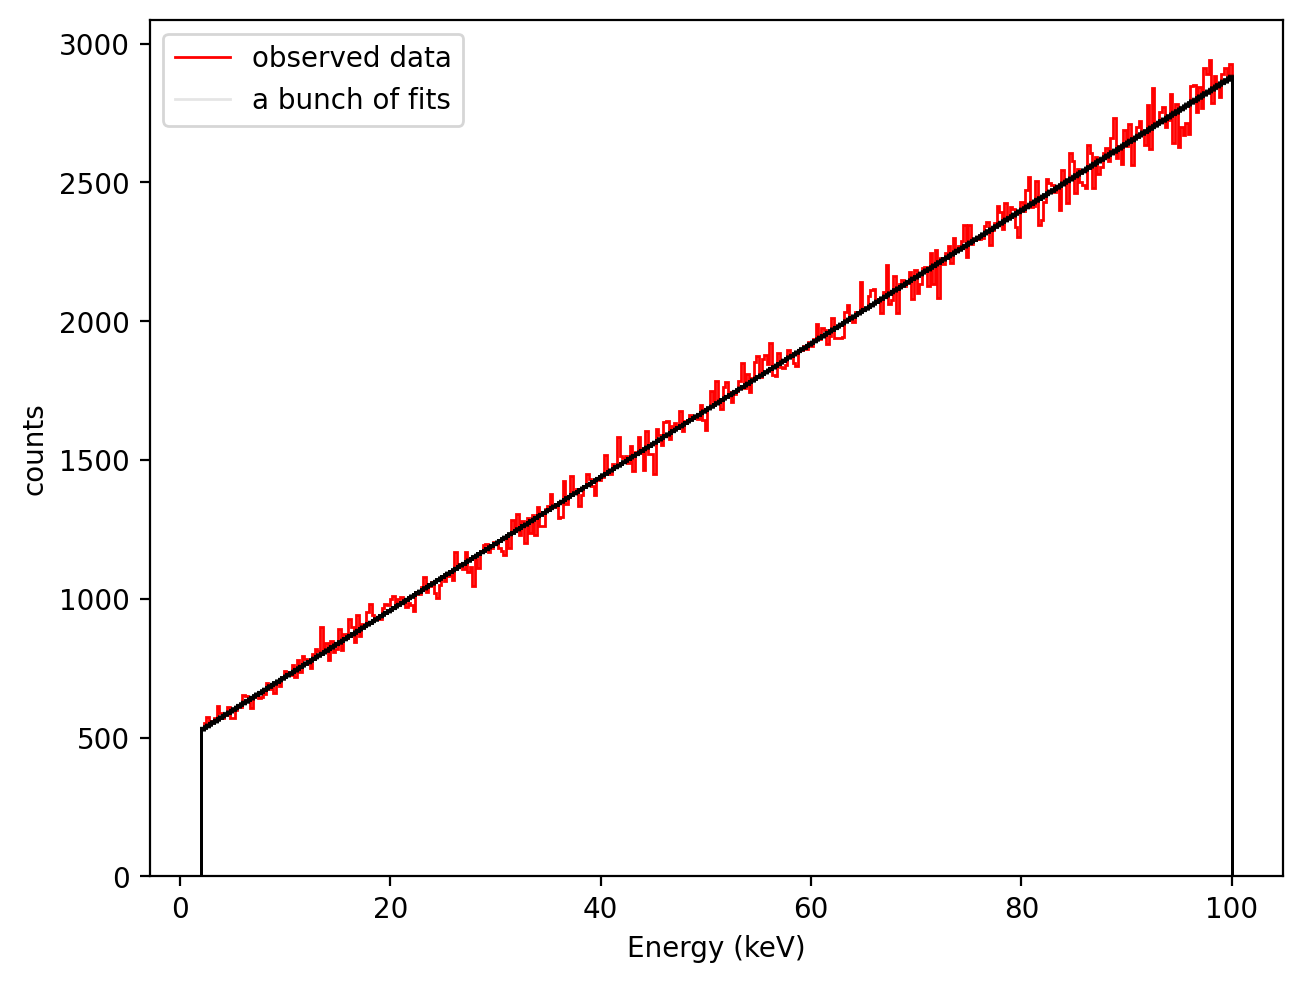

In [8]:
samples_burn = 2000
indices = np.arange(chain.shape[0])

a_sample = np.random.choice(indices[samples_burn:], 100)
sampled_params = [chain[i] for i in a_sample]

fig, ax = plt.subplots(layout='constrained')

ax.stairs(
    spec.counts.to_value(u.ct), spec.count_energy_edges.to_value(u.keV),
    color='red',
    label='observed data'
)

cts_de = np.diff(spec.count_energy_edges)
mod = fit_models.Line()

first_kw = {'label': 'a bunch of fits'}
for sp in sampled_params:
    mod.slope.value, mod.intercept.value = sp
    evald = mod.evaluate(spec.photon_energy_edges)
    photons = evald * spec.effective_exposure * cts_de
    cts = spec.response_matrix @ photons

    ax.stairs(
        cts.to_value(u.ct),
        spec.count_energy_edges.to_value(u.keV),
        color='black', alpha=0.1,
        **first_kw
    )
    first_kw = {}

ax.legend()
ax.set(xlabel='Energy (keV)', ylabel='counts')
plt.show()

### You could take quantiles on the evaluated models too in order to get "confidence intervals" or "credible regions."